In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Import and analyse labelled data

In [2]:
# Data for multiple users
# data = pd.concat([pd.read_csv(f"labeled_data/{i}.csv") for i in range(1, 4)], ignore_index=True)

# Data for 1 user only
raw_data = pd.read_csv(f"labeled_data/1.csv")

In [3]:
raw_data.sample(5)

,Surface,SensorLocation,PacketCounter,SampleTimeFine,Acc_X,Acc_Y,Acc_Z,FreeAcc_X,FreeAcc_Y,FreeAcc_Z,...,OriInc_q3,Roll,Pitch,Yaw,Latitude,Longitude,Altitude,Vel_X,Vel_Y,Vel_Z
377789,SlpD,Right shank,10915,NaN,20.302125,4.750766,-15.437711,18.765416,-7.795731,6.310039,...,0.019859,-66.187886,-70.161836,13.832557,NaN,NaN,0.0,NaN,NaN,NaN
360376,SlpD,Left shank,11407,NaN,22.567066,3.546853,7.841319,-9.803449,18.032393,2.915148,...,0.005769,170.788066,-49.134070,131.334588,NaN,NaN,0.0,NaN,NaN,NaN
468835,BnkR,Wrist,2547,NaN,-9.875406,2.246028,1.705542,-0.119434,-2.416477,0.168462,...,-0.001738,52.352050,60.460269,87.134725,NaN,NaN,0.0,NaN,NaN,NaN
117055,SlpU,Right thigh,29063,NaN,9.610380,-0.628624,0.610125,0.779775,-0.599772,-0.213013,...,-0.000972,-127.081475,-85.071789,-88.262633,NaN,NaN,0.0,NaN,NaN,NaN
198876,BnkL,Trunk,22330,NaN,7.633512,0.072500,-3.175568,0.931309,-2.582244,-2.013671,...,0.000321,-148.697162,-86.088189,71.106606,NaN,NaN,0.0,NaN,NaN,NaN


In [4]:
raw_data.columns

Index(['Surface', 'SensorLocation', 'PacketCounter', 'SampleTimeFine', 'Acc_X',
       'Acc_Y', 'Acc_Z', 'FreeAcc_X', 'FreeAcc_Y', 'FreeAcc_Z', 'Gyr_X',
       'Gyr_Y', 'Gyr_Z', 'Mag_X', 'Mag_Y', 'Mag_Z', 'VelInc_X', 'VelInc_Y',
       'VelInc_Z', 'OriInc_q0', 'OriInc_q1', 'OriInc_q2', 'OriInc_q3', 'Roll',
       'Pitch', 'Yaw', 'Latitude', 'Longitude', 'Altitude', 'Vel_X', 'Vel_Y',
       'Vel_Z'],
      dtype='object')

In [5]:
data = raw_data.drop(["PacketCounter", "SampleTimeFine", "Latitude", "Longitude", "Vel_X", "Vel_Y", "Vel_Z"], axis=1)

In [6]:
data.dropna(axis=0, how="any", inplace=True)

In [7]:
surface_cats, surface_labels = data["Surface"].factorize()
print(sorted(set(surface_cats)), surface_labels)

sensor_loc_cats, sensor_loc_labels = data["SensorLocation"].factorize()
print(sorted(set(sensor_loc_cats)), sensor_loc_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] Index(['FE', 'SlpU', 'BnkR', 'StrD', 'CALIB', 'SlpD', 'StrU', 'CS', 'BnkL',
       'GR'],
      dtype='object')
[0, 1, 2, 3, 4, 5] Index(['Left shank', 'Trunk', 'Right thigh', 'Right shank', 'Wrist',
       'Left thigh'],
      dtype='object')


In [8]:
data["Surface"] = surface_cats
data["SensorLocation"] = sensor_loc_cats

In [9]:
# Visually check that columns match after factorisation
pd.concat([data[data["Surface"] == 4]["Acc_X"], raw_data[raw_data["Surface"] == "CALIB"]["Acc_X"]], axis=1)

,Acc_X,Acc_X
6172,9.569814,9.569814
6173,9.627721,9.627721
6174,9.677289,9.677289
6175,9.665299,9.665299
6176,9.660753,9.660753
...,...,...
555484,9.252919,9.252919
555485,9.175003,9.175003
555486,9.230843,9.230843
555487,9.417961,9.417961


In [10]:
# Drop calibration data
data = data[data["Surface"] != 4]

In [11]:
print(f"Total data count {len(data)}")
data.sample(5)

Total data count 517568


,Surface,SensorLocation,Acc_X,Acc_Y,Acc_Z,FreeAcc_X,FreeAcc_Y,FreeAcc_Z,Gyr_X,Gyr_Y,...,VelInc_Y,VelInc_Z,OriInc_q0,OriInc_q1,OriInc_q2,OriInc_q3,Roll,Pitch,Yaw,Altitude
350357,3,1,2.441071,1.485967,-2.506955,-2.241226,1.424042,-7.092254,-0.415925,-0.113452,...,0.014821,-0.025087,0.999998,-0.002080,-0.000567,0.000562,-170.994890,-82.253580,-77.002377,0.0
298852,0,4,-16.237393,2.763484,1.276223,0.756011,0.809924,6.670305,1.071417,0.141596,...,0.028342,0.013028,0.999974,0.005357,0.000708,-0.004786,48.401224,77.617949,-82.671224,0.0
325259,3,3,5.189669,6.174877,-9.746972,4.093290,-7.629141,-0.591248,2.496012,5.003868,...,0.064134,-0.097912,0.999330,0.012477,0.025014,0.023632,155.177615,-69.163681,109.502061,0.0
159349,8,0,19.533171,-4.023742,-3.815683,-0.030339,5.123818,9.828564,-0.331695,8.345273,...,-0.043120,-0.046172,0.999023,-0.001658,0.041713,-0.014501,-40.602144,-84.264815,159.500646,0.0
409716,5,2,31.967439,4.624645,-3.187620,10.369112,-8.845116,19.643884,-0.710602,-1.637623,...,0.046827,-0.029424,0.999958,-0.003553,-0.008188,0.002150,-1.413373,-72.727668,-59.664241,0.0


In [12]:
data.dtypes

Surface             int64
SensorLocation      int64
Acc_X             float64
Acc_Y             float64
Acc_Z             float64
FreeAcc_X         float64
FreeAcc_Y         float64
FreeAcc_Z         float64
Gyr_X             float64
Gyr_Y             float64
Gyr_Z             float64
Mag_X             float64
Mag_Y             float64
Mag_Z             float64
VelInc_X          float64
VelInc_Y          float64
VelInc_Z          float64
OriInc_q0         float64
OriInc_q1         float64
OriInc_q2         float64
OriInc_q3         float64
Roll              float64
Pitch             float64
Yaw               float64
Altitude          float64
dtype: object

### Visualise data

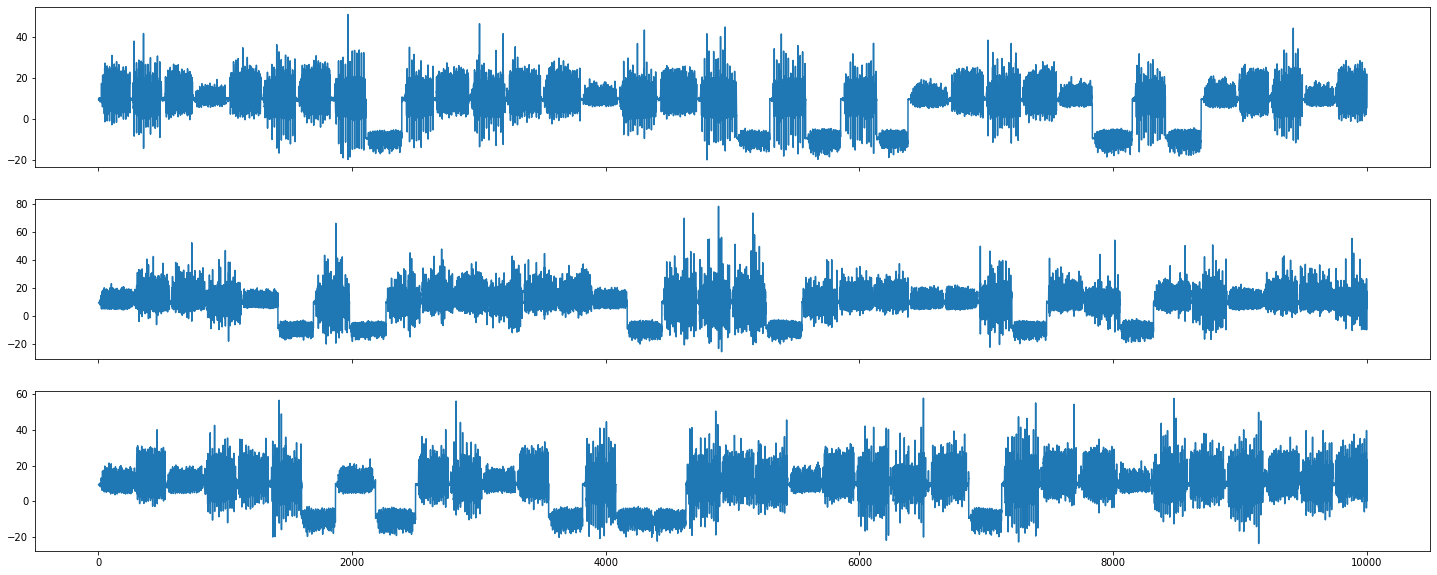

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(25, 10))

surface_1 = data[data["Surface"] == 0]["Acc_X"]
ax1.plot(np.linspace(1, 10000, len(surface_1)), surface_1)

surface_2 = data[data["Surface"] == 1]["Acc_X"]
ax2.plot(np.linspace(1, 10000, len(surface_2)), surface_2)

surface_3 = data[data["Surface"] == 2]["Acc_X"]
ax3.plot(np.linspace(1, 10000, len(surface_3)), surface_3)

### Apply Butterworth filter to data

In [14]:
columns_to_filter = data.columns[2:]
sos = signal.butter(2, 6, btype="lp", fs=100, output="sos")
for c in columns_to_filter:
    data[c] = signal.sosfilt(sos, data[c])


In [15]:
data.sample(5)

,Surface,SensorLocation,Acc_X,Acc_Y,Acc_Z,FreeAcc_X,FreeAcc_Y,FreeAcc_Z,Gyr_X,Gyr_Y,...,VelInc_Y,VelInc_Z,OriInc_q0,OriInc_q1,OriInc_q2,OriInc_q3,Roll,Pitch,Yaw,Altitude
282601,8,2,13.120275,-0.144983,4.579489,-0.334893,0.223452,4.131173,0.334633,-0.387316,...,-0.001123,0.046201,0.999982,0.001673,-0.001937,0.002754,-5.321299,-69.976242,100.043068,0.0
422673,7,4,-9.277402,1.238101,0.247589,-1.062933,-0.691256,-0.536956,0.268946,0.153401,...,0.012490,0.002562,0.999998,0.001345,0.000767,-0.001282,44.303475,77.201186,67.060038,0.0
88216,6,3,19.905197,-5.299304,-5.086539,4.516840,-10.220543,8.802918,-2.489399,-2.157592,...,-0.054762,-0.047770,0.999754,-0.012446,-0.010787,-0.009441,153.705313,-60.394621,-107.869137,0.0
242420,1,2,9.905466,-0.402836,-1.770775,0.054677,-0.089459,-0.031378,-0.044284,0.020941,...,-0.004021,-0.017706,1.000001,-0.000221,0.000105,-0.000065,-167.676086,-81.469415,-41.559681,0.0
493944,8,3,20.040752,7.425560,-17.471517,3.002544,21.960557,4.288451,2.160035,4.754287,...,0.080567,-0.178987,0.999404,0.010798,0.023766,0.020873,-75.171478,-71.354485,114.140599,0.0


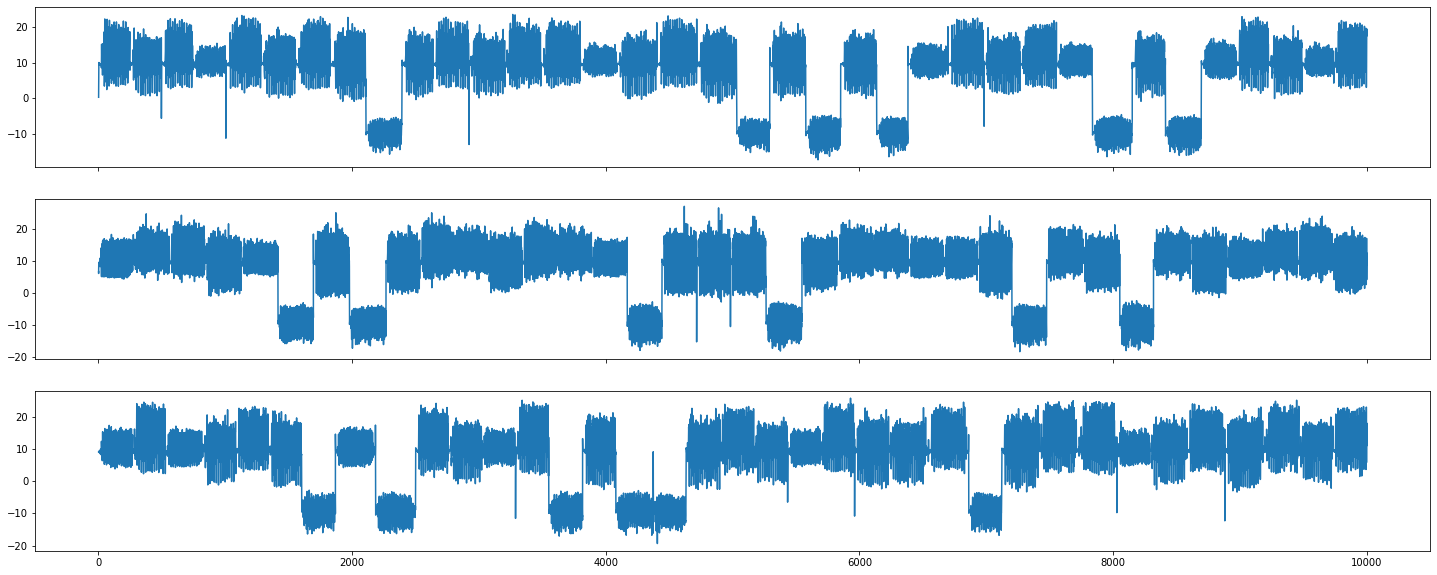

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(25, 10))

surface_1 = data[data["Surface"] == 0]["Acc_X"]
ax1.plot(np.linspace(1, 10000, len(surface_1)), surface_1)

surface_2 = data[data["Surface"] == 1]["Acc_X"]
ax2.plot(np.linspace(1, 10000, len(surface_2)), surface_2)

surface_3 = data[data["Surface"] == 2]["Acc_X"]
ax3.plot(np.linspace(1, 10000, len(surface_3)), surface_3)

### Estimate mutual information for the columns

In [17]:
target = data["Surface"]
discrete_features = data.dtypes != np.float64

X = data[discrete_features.index[1:len(discrete_features)-1]]

In [18]:
discrete_features[1:len(discrete_features)-1]

SensorLocation     True
Acc_X             False
Acc_Y             False
Acc_Z             False
FreeAcc_X         False
FreeAcc_Y         False
FreeAcc_Z         False
Gyr_X             False
Gyr_Y             False
Gyr_Z             False
Mag_X             False
Mag_Y             False
Mag_Z             False
VelInc_X          False
VelInc_Y          False
VelInc_Z          False
OriInc_q0         False
OriInc_q1         False
OriInc_q2         False
OriInc_q3         False
Roll              False
Pitch             False
Yaw               False
dtype: bool

In [19]:
X

,SensorLocation,Acc_X,Acc_Y,Acc_Z,FreeAcc_X,FreeAcc_Y,FreeAcc_Z,Gyr_X,Gyr_Y,Gyr_Z,...,VelInc_X,VelInc_Y,VelInc_Z,OriInc_q0,OriInc_q1,OriInc_q2,OriInc_q3,Roll,Pitch,Yaw
0,0,0.274572,0.039547,0.029423,0.000000,0.000000,0.005583,0.000461,-0.000812,-0.000278,...,0.002746,0.000395,0.000295,0.027860,0.000002,-0.000004,-0.000001,1.484915,-2.223763,-3.357532
1,0,1.222236,0.180121,0.124361,0.010749,-0.008279,0.017925,0.003322,-0.003614,-0.001227,...,0.012222,0.001800,0.001246,0.124686,0.000017,-0.000018,-0.000006,6.460350,-9.947169,-14.892581
2,0,2.712953,0.410293,0.259897,0.049522,-0.037562,0.016477,0.010874,-0.007971,-0.002987,...,0.027129,0.004101,0.002604,0.279059,0.000054,-0.000040,-0.000015,14.048316,-22.251084,-33.034120
3,0,4.331996,0.670756,0.396961,0.112421,-0.080921,-0.017284,0.024137,-0.012369,-0.005799,...,0.043320,0.006704,0.003978,0.450005,0.000121,-0.000062,-0.000029,22.151792,-35.866961,-52.905943
4,0,5.828968,0.934256,0.529149,0.193133,-0.110968,-0.079858,0.042188,-0.015503,-0.009929,...,0.058290,0.009336,0.005302,0.611627,0.000211,-0.000078,-0.000050,29.673240,-48.734880,-71.589983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558709,0,10.964821,-0.021870,-4.546547,-0.945116,-5.098233,0.546932,0.743814,-2.219710,-0.728531,...,0.110250,-0.001151,-0.043889,0.999608,0.003721,-0.011096,-0.003643,84.097977,-76.051035,-153.345997
558710,0,11.195818,0.945932,-3.477958,-0.702196,-3.628974,1.128230,1.284100,-1.859240,-0.690389,...,0.112378,0.008737,-0.033410,0.999704,0.006421,-0.009295,-0.003452,89.171513,-75.808127,-157.842392
558711,0,11.371426,1.745407,-2.662180,-0.446572,-2.481636,1.590433,1.343089,-1.594546,-0.598439,...,0.113994,0.016921,-0.025449,0.999789,0.006716,-0.007972,-0.002992,93.697180,-75.486002,-161.726226
558712,0,11.406374,2.179738,-2.148389,-0.328878,-1.764614,1.803741,1.093489,-1.393152,-0.506810,...,0.114246,0.021404,-0.020497,0.999858,0.005467,-0.006965,-0.002534,97.565948,-75.118826,-165.073126


In [20]:
y = data["Surface"]
y

0         0
1         0
2         0
3         0
4         0
         ..
558709    5
558710    5
558711    5
558712    5
558713    5
Name: Surface, Length: 517568, dtype: int64

In [21]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# mi_scores = make_mi_scores(X, y, discrete_features[1:len(discrete_features)-1])
# mi_scores

### Random Forest classification

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=1
)

In [23]:
X_train.head(3)

,SensorLocation,Acc_X,Acc_Y,Acc_Z,FreeAcc_X,FreeAcc_Y,FreeAcc_Z,Gyr_X,Gyr_Y,Gyr_Z,...,VelInc_X,VelInc_Y,VelInc_Z,OriInc_q0,OriInc_q1,OriInc_q2,OriInc_q3,Roll,Pitch,Yaw
102100,4,-7.354319,1.719870,0.410605,0.996279,1.246736,-2.414935,-0.409173,0.055742,0.626023,...,-0.073595,0.016982,0.004090,0.999993,-0.002046,0.000279,0.003130,51.856887,66.822430,-100.315728
71070,1,11.349582,-1.149446,-5.539605,0.045886,-4.119759,2.180655,0.628379,-0.280362,-0.017052,...,0.113570,-0.011330,-0.055279,0.999992,0.003142,-0.001402,-0.000085,-167.268196,-82.403023,89.797393
345060,2,14.204018,3.118352,4.969922,-5.552640,0.592463,4.509151,0.815767,-0.521816,0.679444,...,0.141727,0.031556,0.050368,0.999948,0.004079,-0.002609,0.003397,7.392920,-50.215510,147.917632


In [24]:
y_train.head(3)

102100    8
71070     8
345060    1
Name: Surface, dtype: int64

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X_train)
# rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv=5)
# rf_cv.fit(X_train, y_train["Surface"])

PCA(n_components=3)

In [26]:
print(pca.feature_names_in_)
print(pca.explained_variance_ratio_)

['SensorLocation' 'Acc_X' 'Acc_Y' 'Acc_Z' 'FreeAcc_X' 'FreeAcc_Y'
 'FreeAcc_Z' 'Gyr_X' 'Gyr_Y' 'Gyr_Z' 'Mag_X' 'Mag_Y' 'Mag_Z' 'VelInc_X'
 'VelInc_Y' 'VelInc_Z' 'OriInc_q0' 'OriInc_q1' 'OriInc_q2' 'OriInc_q3'
 'Roll' 'Pitch' 'Yaw']
[0.52974408 0.35366817 0.11203733]


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train[["SensorLocation", "Acc_X", "Acc_Y"]], y_train)

predictions = clf.predict(X_test[["SensorLocation", "Acc_X", "Acc_Y"]])

/Users/aidarmamytov/University/Dissertation/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [34]:
(predictions == y_test).sum() / len(predictions)

0.08950802145925511